In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
data_train=pd.read_csv('Train.csv')
data_test=pd.read_csv('Test.csv')

In [5]:
data_train['Date'] = pd.to_datetime(data_train['Date'],format='%d/%m/%Y')
data_test['Date'] = pd.to_datetime(data_test['Date'],format='%d/%m/%Y')

In [6]:
data_train.head()

,Unnamed: 0,Date,Close,High,Open,Low,Volume,R
0,0,2001-12-06,1.228,1.314,1.306,1.220,1736807936,0.02057
1,1,2001-12-07,1.220,1.245,1.237,1.220,412532992,-0.00654
2,2,2001-12-11,1.168,1.220,1.220,1.168,409158016,-0.04356
3,3,2001-12-12,1.203,1.211,1.177,1.168,307291008,0.02953
4,4,2001-12-13,1.203,1.211,1.203,1.203,372960992,0.00000


In [7]:
data_train.describe()

,Unnamed: 0,Date,Close,High,Open,Low,Volume,R
count,4648.000000,4648,4648.000000,4648.000000,4648.000000,4648.000000,4.648000e+03,4648.000000
mean,2323.500000,2011-06-09 21:11:09.191049984,16.419351,16.599105,16.428665,16.250878,5.850492e+07,0.000706
min,0.000000,2001-12-06 00:00:00,1.072000,1.118000,1.081000,1.063000,2.054280e+06,-0.292120
25%,1161.750000,2006-09-05 18:00:00,9.508000,9.597000,9.508000,9.419000,3.213600e+07,-0.009325
50%,2323.500000,2011-06-15 12:00:00,16.517000,16.683000,16.548000,16.375000,4.748200e+07,0.000000
75%,3485.250000,2016-03-10 06:00:00,21.130000,21.370000,21.166000,20.894000,7.085708e+07,0.010200
max,4647.000000,2020-12-16 00:00:00,40.441000,40.922000,40.303000,39.615000,1.736808e+09,0.149540
std,1341.906355,NaN,9.346045,9.433898,9.353052,9.267274,4.872640e+07,0.020466


In [8]:
data_test.describe()

,Unnamed: 0,Date,Close,High,Open,Low,Volume,R
count,1163.000000,1163,1163.000000,1163.000000,1163.000000,1163.000000,1.163000e+03,1163.000000
mean,581.000000,2023-05-13 17:20:04.127257088,29.777912,30.056767,29.782792,29.510935,5.030604e+07,0.000005
min,0.000000,2020-12-17 00:00:00,25.314000,25.743000,25.528000,25.314000,4.740650e+06,-0.054080
25%,290.500000,2022-03-01 12:00:00,28.909000,29.181500,28.927000,28.663000,3.026828e+07,-0.007445
50%,581.000000,2023-05-17 00:00:00,30.005000,30.275000,30.023000,29.754000,4.431662e+07,0.000000
75%,871.500000,2024-07-24 12:00:00,30.958000,31.185000,30.940000,30.730000,6.373834e+07,0.007390
max,1162.000000,2025-10-03 00:00:00,33.572000,33.949000,33.572000,33.195000,2.529052e+08,0.062260
std,335.873488,NaN,1.520731,1.529527,1.532331,1.521798,2.893472e+07,0.012284


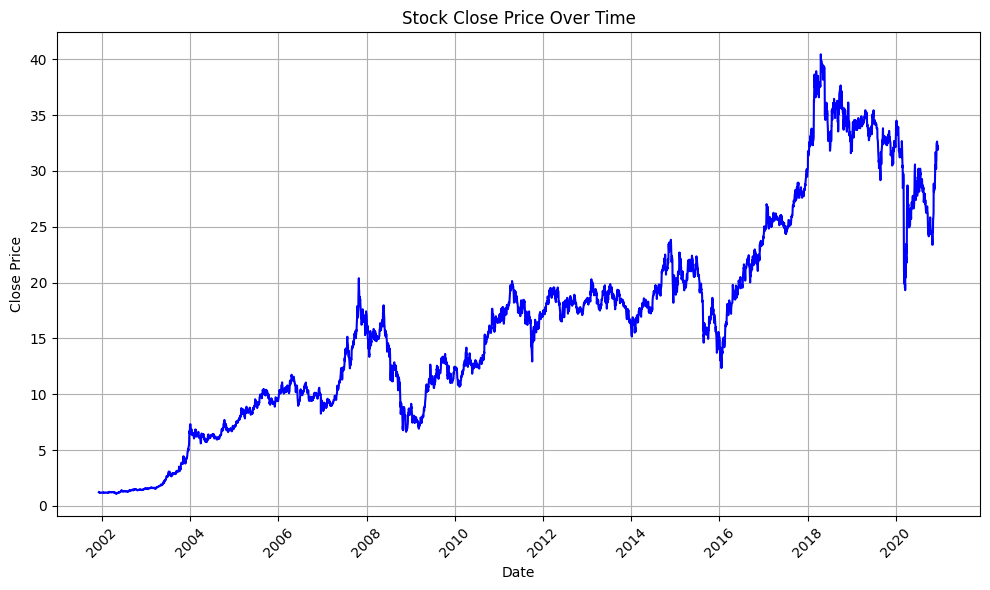

In [9]:
# Plotting Close
plt.figure(figsize=(10, 6))
plt.plot(data_train['Date'], data_train['Close'], linestyle='-', color='b')

plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

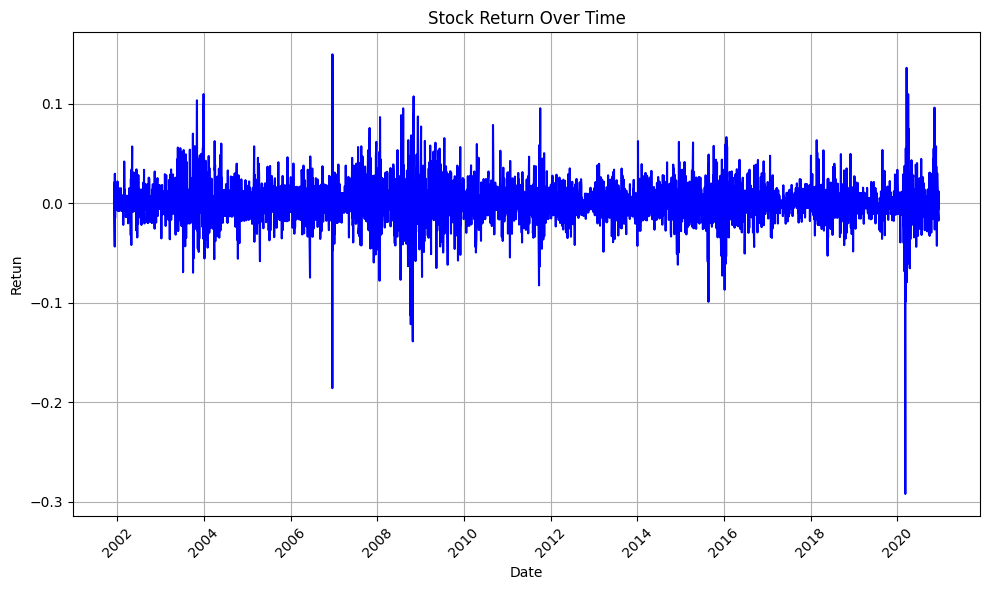

In [10]:
# Plotting Return
plt.figure(figsize=(10, 6))
plt.plot(data_train['Date'], data_train['R'], linestyle='-', color='b')

plt.title('Stock Return Over Time')
plt.xlabel('Date')
plt.ylabel('Retun')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

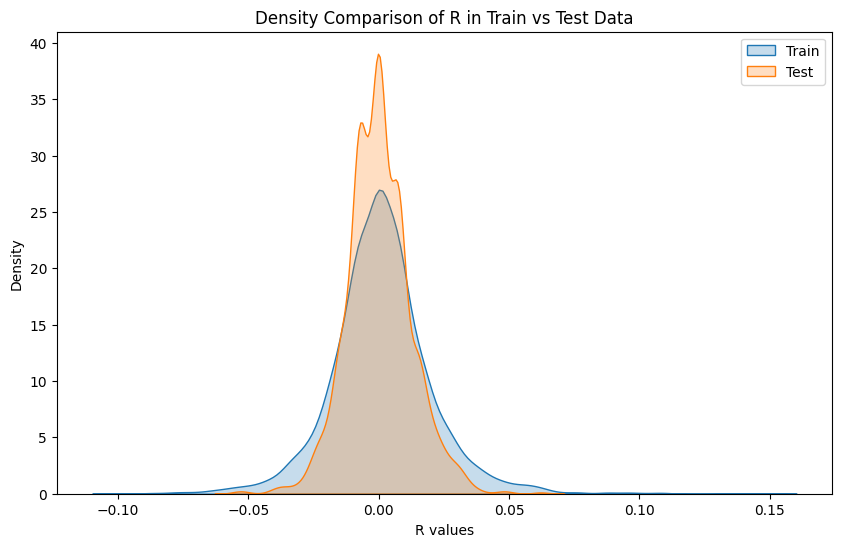

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data_train[data_train['R']>-0.1]['R'], label='Train', fill=True)
sns.kdeplot(data_test[data_test['R']>-0.1]['R'], label='Test', fill=True)
plt.xlabel('R values')
plt.ylabel('Density')
plt.title('Density Comparison of R in Train vs Test Data')
plt.legend()
plt.show()

In [29]:
data_train['Y']=np.where(data_train['R']>0,1,0)
data_test['Y']=np.where(data_test['R']>0,1,0)

Preparing Data

In [32]:
def create_sequences(data_x,data_y, n_steps):
    X, y = list(), list()
    for i in range(len(data_x)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data_x)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_x[i:end_ix], data_y[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
N_steps=50
X_train, y_train = create_sequences(data_train['R'],data_train['R'], N_steps)
X_test, y_test = create_sequences(data_test['R'],data_test['R'], N_steps)


In [39]:
X_train.shape

(4598, 50)

In [42]:
y_train.shape

(4598,)

In [43]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
y_train.shape=(y_train.shape[0],1)

CNN Model

In [66]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(N_steps, 1)))

model.add(MaxPooling1D(pool_size=4))

model.add(Flatten())

model.add(Dense(32, activation='relu'))

model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [67]:
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 47, 32)         │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,489 (44.88 KB)

 Trainable params: 11,489 (44.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
history = model.fit(X_train, y_train,
                   epochs=200,
                   verbose=0,
                   validation_data=(X_test, y_test))

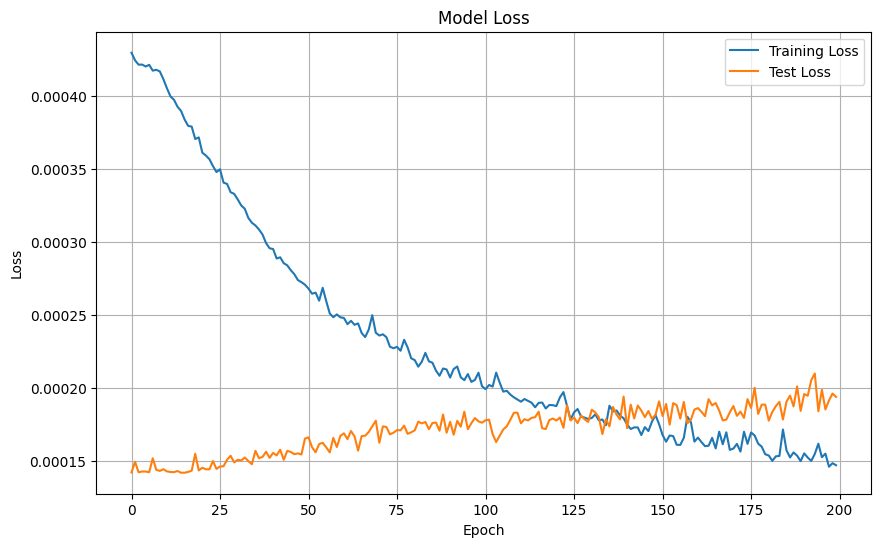

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
mean_squared_error(y_test,model.predict(X_test))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.00019380615221487588

In [72]:
mean_squared_error(y_test,[np.mean(y_train)]*len(y_test))

0.00014195909935480665

RNN Model

In [73]:
    model = Sequential([
        SimpleRNN(units=64, return_sequences=True, input_shape=(N_steps, 1)),
        Dropout(0.2),

        SimpleRNN(units=32, return_sequences=False),


        Dense(32),
        Dense(1)
    ])

    model.compile(optimizer='adam',
                 loss='mse',
                 )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,417 (32.88 KB)

 Trainable params: 8,417 (32.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
history = model.fit(X_train, y_train,
                   epochs=200,
                   verbose=0,
                   validation_data=(X_test, y_test))

In [77]:
mean_squared_error(y_test,model.predict(X_test))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


0.00014485723768273528

In [78]:
mean_squared_error(y_test,[np.mean(y_train)]*len(y_test))

0.00014195909935480665

Binary Classification

In [80]:
N_steps=50
X_train, y_train = create_sequences(data_train['R'],data_train['Y'], N_steps)
X_test, y_test = create_sequences(data_test['R'],data_test['Y'], N_steps)

In [81]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [82]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(N_steps, 1)))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(50, activation='relu'))

model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

# Compile the model for binary classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
model.summary()


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0,

)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 49, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │        76,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,281 (903.45 KB)

 Trainable params: 77,093 (301.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,188 (602.30 KB)

In [88]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [91]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.65      0.65       725
           1       0.36      0.36      0.36       388

    accuracy                           0.55      1113
   macro avg       0.51      0.51      0.51      1113
weighted avg       0.55      0.55      0.55      1113



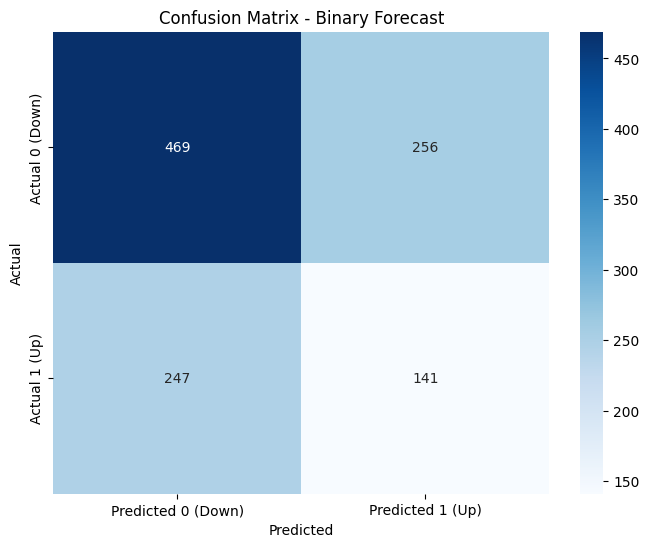

In [92]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0 (Down)', 'Predicted 1 (Up)'],
            yticklabels=['Actual 0 (Down)', 'Actual 1 (Up)'])
plt.title('Confusion Matrix - Binary Forecast')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()